In [4]:
# =============================================================================
# THREE-STAGE DINOV3 FINE-TUNING SCRIPT
# =============================================================================
# This script is designed to be run in a notebook-like environment (e.g., Jupyter, VSCode)
# where each major section (marked as "CELL") is executed sequentially.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from transformers import AutoModel
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import os
import time

# =============================================================================
# CELL 0: SHARED CONFIGURATION AND SETUP
# =============================================================================

# --- Main Configuration for All Stages (Updated as per your request) ---
config = {
    # CORRECTED: Point this to the main folder containing your class subdirectories (e.g., Alarippu, Jathiswaram)
    'base_dir': r'images',
    'model_name': 'facebook/dinov3-convnext-tiny-pretrain-lvd1689m',
    'img_size': 224,
    'num_workers': 4,

    # Stage 1: Head Training
    'stage1_save_path': r'stage1_head_trained.pth',
    'stage1_epochs': 15,
    'stage1_lr': 1e-3,
    'stage1_batch_size': 32,

    # Stage 2: Full Network Training
    'stage2_load_path': r'stage1_head_trained.pth',
    'stage2_save_path': r'stage2_full_trained.pth',
    'stage2_epochs': 30,
    'stage2_lr': 1e-4,
    'stage2_batch_size': 16,
    'stage2_patience': 7,

    # Stage 3: Fine-tuning
    'stage3_load_path': r'stage2_full_trained.pth',
    'stage3_save_path': r'best_finetuned_model.pth', # Final model
    'stage3_epochs': 25,
    'stage3_lr': 1e-5,
    'stage3_batch_size': 16,
    'stage3_patience': 5,
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Shared Functions ---

# CORRECTED: This function now automatically splits your data
def get_data_loaders(base_dir, img_size, batch_size, num_workers):
    """
    Loads images from a single directory and automatically splits them into
    training, validation, and test sets.
    """
    # Define separate transforms for training (with augmentation) and validation/testing
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # To apply different transforms, we create two dataset instances from the same folder
    # This is a standard and effective way to handle this in PyTorch.
    dataset_for_training = datasets.ImageFolder(root=base_dir, transform=train_transform)
    dataset_for_eval = datasets.ImageFolder(root=base_dir, transform=val_test_transform)

    # Define split sizes (e.g., 70% train, 15% validation, 15% test)
    total_size = len(dataset_for_training)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    print(f"Splitting {total_size} total images into: {train_size} Train, {val_size} Val, {test_size} Test")

    # Split the indices of the dataset
    indices = list(range(total_size))
    # It's good practice to shuffle before splitting
    import random
    random.seed(42) # for reproducibility
    random.shuffle(indices)
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size : train_size + val_size]
    test_indices = indices[train_size + val_size :]

    # Create Subset objects with the correct underlying dataset (and thus transform)
    train_dataset = Subset(dataset_for_training, train_indices)
    val_dataset = Subset(dataset_for_eval, val_indices)
    test_dataset = Subset(dataset_for_eval, test_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    num_classes = len(dataset_for_training.classes)
    class_names = dataset_for_training.classes

    return train_loader, val_loader, test_loader, num_classes, class_names


class TransformersClassifier(nn.Module):
    """Wrapper for Hugging Face models with a custom classification head."""
    def __init__(self, model_name, num_classes, drop_rate=0.1):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        feature_dim = self.backbone.config.hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512),
            nn.GELU(), nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        features = torch.mean(outputs.last_hidden_state, dim=1)
        return self.classifier(features)

def train_one_epoch(model, loader, optimizer, criterion, device, desc=""):
    """Generic training loop for one epoch."""
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(loader, desc=f"Training ({desc})"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion, device, desc=""):
    """Generic validation loop."""
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=f"Validating ({desc})"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), accuracy


Using device: cuda



           ### EXECUTING CELL 5: BASELINE CNN (RESNET18) TRAINING ###           
Splitting 928 total images into: 649 Train, 139 Val, 140 Test

--- CNN Training Epoch 1/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Train Loss: 3.1733 | Train Acc: 6.47%
Val Loss: 3.1321 | Val Acc: 10.07%
🎉 New best val acc: 10.07%. Saving CNN model...

--- CNN Training Epoch 2/20 ---


Validating CNN: 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


Train Loss: 3.0152 | Train Acc: 16.33%
Val Loss: 2.9580 | Val Acc: 20.14%
🎉 New best val acc: 20.14%. Saving CNN model...

--- CNN Training Epoch 3/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Train Loss: 2.7703 | Train Acc: 26.35%
Val Loss: 2.7519 | Val Acc: 18.71%

--- CNN Training Epoch 4/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Train Loss: 2.4499 | Train Acc: 37.44%
Val Loss: 2.4417 | Val Acc: 33.81%
🎉 New best val acc: 33.81%. Saving CNN model...

--- CNN Training Epoch 5/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Train Loss: 2.1573 | Train Acc: 49.15%
Val Loss: 2.1672 | Val Acc: 41.01%
🎉 New best val acc: 41.01%. Saving CNN model...

--- CNN Training Epoch 6/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Train Loss: 1.8530 | Train Acc: 58.55%
Val Loss: 1.9260 | Val Acc: 46.04%
🎉 New best val acc: 46.04%. Saving CNN model...

--- CNN Training Epoch 7/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Train Loss: 1.4859 | Train Acc: 69.03%
Val Loss: 1.6017 | Val Acc: 59.71%
🎉 New best val acc: 59.71%. Saving CNN model...

--- CNN Training Epoch 8/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Train Loss: 1.2285 | Train Acc: 77.04%
Val Loss: 1.5518 | Val Acc: 58.27%

--- CNN Training Epoch 9/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Train Loss: 0.9524 | Train Acc: 82.59%
Val Loss: 1.3084 | Val Acc: 60.43%
🎉 New best val acc: 60.43%. Saving CNN model...

--- CNN Training Epoch 10/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Train Loss: 0.7364 | Train Acc: 89.21%
Val Loss: 1.2186 | Val Acc: 68.35%
🎉 New best val acc: 68.35%. Saving CNN model...

--- CNN Training Epoch 11/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Train Loss: 0.5833 | Train Acc: 92.60%
Val Loss: 1.0665 | Val Acc: 73.38%
🎉 New best val acc: 73.38%. Saving CNN model...

--- CNN Training Epoch 12/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Train Loss: 0.4354 | Train Acc: 95.22%
Val Loss: 1.0339 | Val Acc: 72.66%

--- CNN Training Epoch 13/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Train Loss: 0.3389 | Train Acc: 95.53%
Val Loss: 0.9617 | Val Acc: 73.38%

--- CNN Training Epoch 14/20 ---


Validating CNN: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Train Loss: 0.2615 | Train Acc: 97.23%
Val Loss: 0.8785 | Val Acc: 76.26%
🎉 New best val acc: 76.26%. Saving CNN model...

--- CNN Training Epoch 15/20 ---


Validating CNN: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Train Loss: 0.2152 | Train Acc: 96.92%
Val Loss: 0.8826 | Val Acc: 76.26%

--- CNN Training Epoch 16/20 ---


Validating CNN: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Train Loss: 0.1801 | Train Acc: 97.23%
Val Loss: 0.8152 | Val Acc: 82.01%
🎉 New best val acc: 82.01%. Saving CNN model...

--- CNN Training Epoch 17/20 ---


Validating CNN: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Train Loss: 0.1412 | Train Acc: 98.31%
Val Loss: 0.8334 | Val Acc: 79.14%

--- CNN Training Epoch 18/20 ---


Validating CNN: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Train Loss: 0.1157 | Train Acc: 99.54%
Val Loss: 0.7377 | Val Acc: 79.86%

--- CNN Training Epoch 19/20 ---


Validating CNN: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Train Loss: 0.0986 | Train Acc: 99.23%
Val Loss: 0.8056 | Val Acc: 76.98%

--- CNN Training Epoch 20/20 ---


Validating CNN: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Train Loss: 0.0945 | Train Acc: 99.23%
Val Loss: 0.7952 | Val Acc: 76.26%

✅ CNN Training Complete. Best Val Acc: 82.01%
Model saved to baseline_cnn_best.pth

                  ### EVALUATING CNN BASELINE ON TEST DATA ###                  


Testing CNN: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]



🏆 CNN Test Accuracy: 0.7571 (75.71%)

Classification Report:
                 precision    recall  f1-score   support

       1.pataka     1.0000    1.0000    1.0000         5
    10.hamsasya     0.3333    0.5714    0.4211         7
      11.anjali     0.8750    0.8750    0.8750         8
12.ardhachandra     0.3750    0.6000    0.4615         5
      13.mukura     1.0000    0.4000    0.5714         5
    14.bhramara     1.0000    0.7273    0.8421        11
  15.suchimukha     0.8000    0.5714    0.6667         7
     16.pallava     1.0000    1.0000    1.0000         4
   17.tripataka     0.8571    1.0000    0.9231         6
 18.mrigasirsha     1.0000    0.6250    0.7692         8
  19.sarpasiras     0.5000    1.0000    0.6667         3
    2.mudrakhya     1.0000    0.7500    0.8571         4
20.vardhamanaka     0.0000    0.0000    0.0000         2
       21.arala     0.3333    0.3333    0.3333         3
   22.urnanabha     0.8333    1.0000    0.9091         5
      23.mukula     0.800

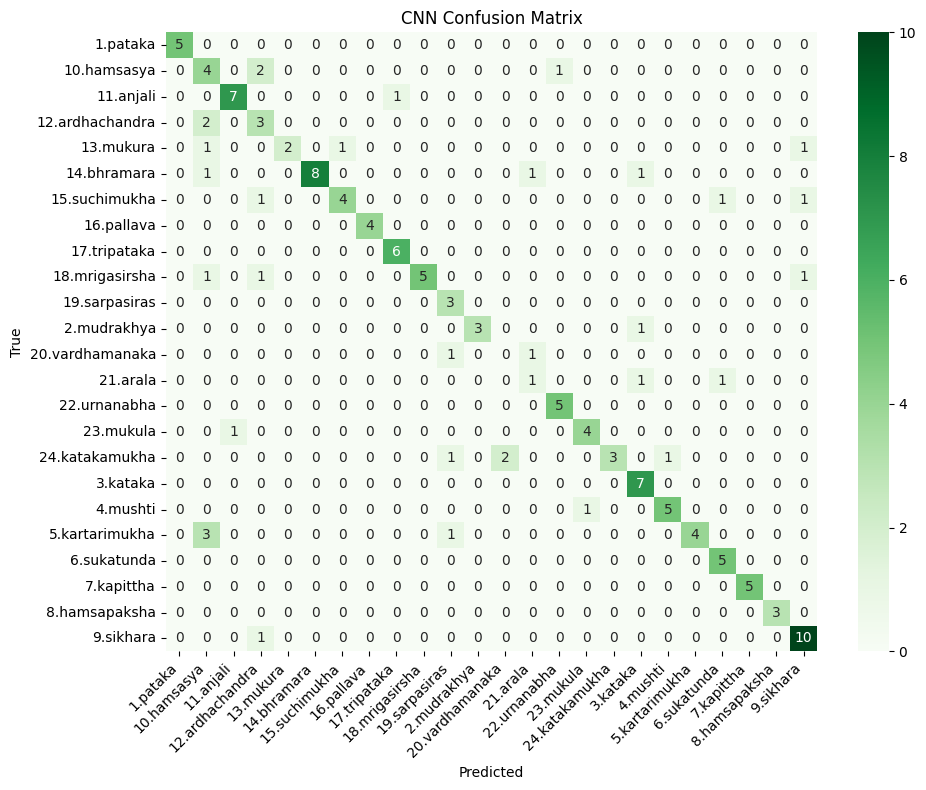

In [5]:
# %%
# =============================================================================
# CELL 5: BASELINE CNN TRAINING (USING SAME SPLITTING TECHNIQUE)
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*80)
print("### EXECUTING CELL 5: BASELINE CNN (RESNET18) TRAINING ###".center(80))
print("="*80)

# 1. Load Data (reuse same split)
train_loader_cnn, val_loader_cnn, test_loader_cnn, num_classes_cnn, class_names_cnn = get_data_loaders(
    config['base_dir'], config['img_size'], batch_size=32, num_workers=config['num_workers']
)

# 2. Define CNN Model (ResNet18 baseline)
class CNNBaseline(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.backbone(x)

cnn_model = CNNBaseline(num_classes_cnn).to(device)

# 3. Define Loss, Optimizer, and Scheduler
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.AdamW(cnn_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='min', patience=3, factor=0.5)

# 4. Training and Validation Loops
num_epochs_cnn = 20
best_val_acc_cnn = 0.0
epochs_no_improve_cnn = 0
patience_cnn = 5
cnn_save_path = "baseline_cnn_best.pth"

for epoch in range(num_epochs_cnn):
    print(f"\n--- CNN Training Epoch {epoch+1}/{num_epochs_cnn} ---")
    cnn_model.train()
    train_loss = 0
    all_preds, all_labels = [], []
    
    for inputs, labels in tqdm(train_loader_cnn, desc="Training CNN"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion_cnn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()
        train_loss += loss.item()
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    train_acc = accuracy_score(all_labels, all_preds)
    train_loss /= len(train_loader_cnn)
    
    # Validation
    cnn_model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader_cnn, desc="Validating CNN"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn_model(inputs)
            loss = criterion_cnn(outputs, labels)
            val_loss += loss.item()
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    val_acc = accuracy_score(val_labels, val_preds)
    val_loss /= len(val_loader_cnn)
    scheduler_cnn.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")
    
    if val_acc > best_val_acc_cnn:
        print(f"🎉 New best val acc: {val_acc:.2%}. Saving CNN model...")
        best_val_acc_cnn = val_acc
        torch.save({'model_state_dict': cnn_model.state_dict()}, cnn_save_path)
        epochs_no_improve_cnn = 0
    else:
        epochs_no_improve_cnn += 1
        if epochs_no_improve_cnn >= patience_cnn:
            print("\nEarly stopping triggered.")
            break

print(f"\n✅ CNN Training Complete. Best Val Acc: {best_val_acc_cnn:.2%}")
print(f"Model saved to {cnn_save_path}")

# 5. Final Evaluation on Test Set
print("\n" + "="*80)
print("### EVALUATING CNN BASELINE ON TEST DATA ###".center(80))
print("="*80)

# Reload best CNN weights
checkpoint_cnn = torch.load(cnn_save_path, map_location=device)
cnn_model.load_state_dict(checkpoint_cnn['model_state_dict'])
cnn_model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader_cnn, desc="Testing CNN"):
        inputs = inputs.to(device)
        outputs = cnn_model(inputs)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"\n🏆 CNN Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")

# Classification Report
report_cnn = classification_report(all_labels, all_preds, target_names=class_names_cnn, digits=4)
print("\nClassification Report:")
print(report_cnn)

# Confusion Matrix
cm_cnn = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names_cnn, yticklabels=class_names_cnn)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
